In [129]:
import sys
import dawis as d
import glob as glob
import os
import numpy as np
import pyregion as pyr
import random
import gc
import h5py
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy.visualization import *
from scipy.stats import kurtosis
from power_ratio import *
from datetime import datetime
from photutils.segmentation import SourceCatalog, detect_sources
import make_results_ERO_noray
import tracemalloc
import matplotlib
import cmasher
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle
from astropy.stats import sigma_clip



In [2]:
# Paths, lists & variables
path_data = '/home/aellien/Euclid_ERO/data/Euclid-VIS-Stack-ERO-Abell2390.DR3'
path_scripts = '/home/aellien/Euclid_ERO/Euclid_ERO_scripts'
path_wavelets = '/home/aellien/Euclid_ERO/wavelets/out8/'
path_plots = '/home/aellien/Euclid_ERO/plots'
path_analysis = '/home/aellien/Euclid_ERO/analysis/'

hdu = fits.open('/home/aellien/Euclid_ERO/data/Euclid-VIS-Stack-ERO-Abell2390.DR3/Euclid-VIS-ERO-Abell2390-LSB.DR3.warp.scaled.crop.input.fits')
header = hdu[0].header
oim = hdu[0].data
xs, ys = oim.shape

In [15]:
nfp = os.path.join(path_wavelets, 'Euclid-VIS-ERO-Abell2390-LSB.DR3.warp.scaled.crop.input.')
opath = nfp + '*ol.it*.hdf5'
opathl = glob.glob(opath)
opathl.sort()

cirim = np.zeros((xs, ys))
recim = np.zeros((xs, ys))

#for i, op in enumerate(opathl):

for i in range(1, 366):
    print(i, end = '\r')
    op = nfp + 'ol.it%03d.hdf5'%i
    with h5py.File(op, "r") as f1:
        for o in f1.keys():
            gc.collect()
            x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
            image = np.copy(f1[o]['image'][()])
            lvlo = np.copy(f1[o]['level'][()])

            recim[ x_min : x_max, y_min : y_max ] += image
            if lvlo >= 7:
                cirim[ x_min : x_max, y_min : y_max ] += image

In [20]:
hduo = fits.PrimaryHDU()
hdu_cirim = fits.ImageHDU(cirim, header = header, name = 'CIRRUS')
hdu_clean = fits.ImageHDU(oim - cirim, header = header, name = 'CLEANED')
hdu_recim = fits.ImageHDU(recim, header = header, name = 'RECONSTRUCTED IMAGE')
hdu_res = fits.ImageHDU(oim - recim, header = header, name = 'RESIDUALS')
hdul = fits.HDUList([hduo, hdu_cirim, hdu_clean, hdu_recim, hdu_res])
hdul.writeto(nfp + 'synth.cirrus.fits', overwrite = True)

hdu_first_pass = fits.PrimaryHDU(oim - recim, header = header)
hdu_first_pass.writeto(os.path.join(path_data, 'cirrus_first_pass.fits'), overwrite = True)
print('ok')

ok


In [3]:
nfp = os.path.join(path_wavelets, 'Euclid-VIS-ERO-Abell2390-LSB.DR3.warp.scaled.crop.input.')
opath = nfp + '*ol.it*.hdf5'
opathl = glob.glob(opath)
opathl.sort()

cirim = np.zeros((xs, ys))

#for i, op in enumerate(opathl):

for i in range(192, 367):
    print(i, end = '\r')
    op = nfp + 'ol.it%03d.hdf5'%i
    with h5py.File(op, "r") as f1:
        for o in f1.keys():
            gc.collect()
            x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
            image = np.copy(f1[o]['image'][()])
            lvlo = np.copy(f1[o]['level'][()])

            if lvlo >= 7:
                cirim[ x_min : x_max, y_min : y_max ] += image


KeyboardInterrupt: 

In [4]:
hdu = fits.open(os.path.join(path_wavelets, 'Euclid-VIS-ERO-Abell2390-LSB.DR3.warp.scaled.crop.input.synth.cirrus.fits'))
first_pass = hdu[1].data

In [5]:
r = pyr.open(os.path.join(path_analysis, 'cluster_cirrus_mask.reg'))
mcl = r.get_mask(hdu = hdu[1])

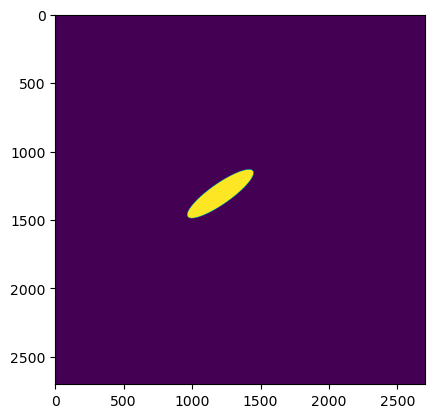

In [7]:
plt.figure()
plt.imshow(mcl)
plt.show()

In [7]:
nfp = os.path.join(path_wavelets, 'cirrus_first_pass.')
opath = nfp + '*ol.it*.hdf5'
opathl = glob.glob(opath)
opathl.sort()
cirim = np.copy(first_pass)
for i in range(62, 416):
    print(i, end = '\r')
    op = nfp + 'ol.it%03d.hdf5'%i
    with h5py.File(op, "r") as f1:
        for o in f1.keys():
            gc.collect()
            x_min, y_min, x_max, y_max = np.copy(f1[o]['bbox'][()])
            image = np.copy(f1[o]['image'][()])
            m = detect_sources(image, threshold = 0., npixels=1)
            c = SourceCatalog(image, m)
            xco = int(c.centroid_quad[0][1] + x_min)
            yco = int(c.centroid_quad[0][0] + y_min)
            xco = np.unravel_index(image.argmax(), image.shape)[0] + x_min
            yco = np.unravel_index(image.argmax(), image.shape)[1] + y_min
            lvlo = np.copy(f1[o]['level'][()])

            if (lvlo >= 4) & (mcl[xco, yco] != True):
                cirim[ x_min : x_max, y_min : y_max ] += image

In [8]:
mcl

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

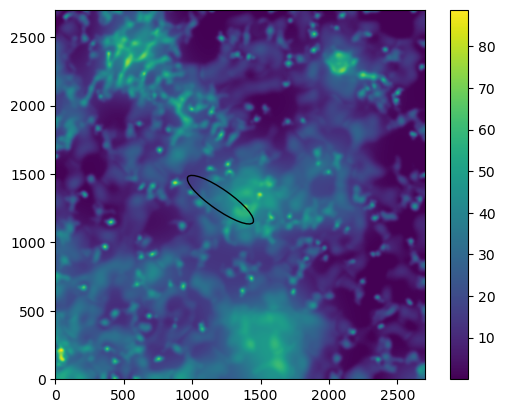

In [8]:
plt.figure()
#plt.imshow(gaussian_filter(cirim, 20), origin = 'lower')
plt.imshow(gaussian_filter(cirim, 10), origin = 'lower')
patch_list1, artist_list1 = r.get_mpl_patches_texts()
for p in patch_list1:
    plt.gca().add_patch(p)
for t in artist_list1:
    plt.gca().add_artist(t)
plt.colorbar()
plt.show()


In [3]:
hduo = fits.PrimaryHDU()
hdu_cirim = fits.ImageHDU(gaussian_filter(cirim, 20), header = header, name = 'CIRRUS')
hdu_clean = fits.ImageHDU(oim - cirim, header = header, name = 'CLEANED')
hdul = fits.HDUList([hduo, hdu_cirim, hdu_clean])
hdul.writeto(nfp + 'synth.cirrus_2nd_pass_lvl4.fits', overwrite = True)


NameError: name 'gaussian_filter' is not defined

In [19]:
# Original size version
# astwarp cirrus_first_pass.synth.cirrus_2nd_pass_lvl4.fits -h1 --scale=10. --output=vis_dawis_cirrus_map_lvl4.fits
hdu = fits.open(os.path.join(path_wavelets, 'vis_dawis_cirrus_map_lvl4.fits'))
osize_cirim = hdu[1].data[:27001, :27001]
hdu_oim = fits.open(os.path.join(path_data, 'Euclid-VIS-ERO-Abell2390-LSB.DR3.rot.crop.fits'))
header = hdu_oim[1].header
oim = hdu_oim[1].data
print(oim.shape, osize_cirim.shape)
residuals = oim - osize_cirim
hduo = fits.PrimaryHDU()
hdu_oim = fits.ImageHDU(oim, header = header, name = 'ORIGINAL')
hdu_cirim = fits.ImageHDU(osize_cirim, header = header, name = 'CIRRUS')
hdu_clean = fits.ImageHDU(oim - osize_cirim, header = header, name = 'CLEANED')
hdul = fits.HDUList([hduo, hdu_oim, hdu_cirim, hdu_clean])
hdul.writeto(os.path.join(path_data, 'Euclid-VIS-ERO-Abell2390-LSB.DR3.dawis_cirrus_map.lvl4.fits'), overwrite = True)


(27001, 27001) (27001, 27001)


In [86]:
nfp = os.path.join(path_wavelets, 'cirrus_first_pass.')
hdu = fits.open(nfp + 'synth.cirrus_2nd_pass_lvl4.fits')
cirim = hdu[1].data
wcs = WCS(hdu[1].header)
hdu = fits.open('/home/aellien/Euclid_ERO/data/Euclid-VIS-Stack-ERO-Abell2390.DR3/Euclid-VIS-ERO-Abell2390-LSB.DR3.warp.scaled.crop.input.fits')
header = hdu[0].header
oim = hdu[0].data

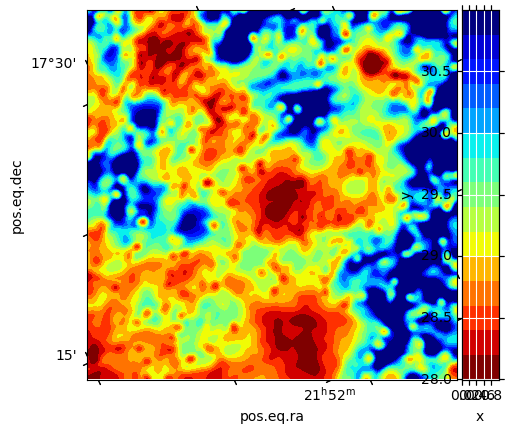

In [87]:
cirim[cirim == 0] = 1E-10
#cirim += 1332 # rough bkf substraction
oim[oim <= 0] = 1E-10
rebin_pix_scale = 0.3 * 10
ZP = 30

# make a color map of fixed colors
cmap = mpl.colors.ListedColormap([ 'white', 'darkblue', 'blue', 'green', 'orange', 'red', 'crimson'])
cmap = plt.cm.jet_r  # define the colormap
#cmap = cmasher.guppy_r

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
bounds= np.linspace(28, 31, 16)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

mag_cirim = np.copy(- 2.5 * np.log10(cirim / rebin_pix_scale**2) + ZP)
mag_oim = np.copy(- 2.5 * np.log10(oim / rebin_pix_scale**2) + ZP)
mag_oim[mag_oim >= 28] = 28
fig = plt.figure()
#ax1 = fig.add_subplot(121, projection = wcs)
#ax1.imshow(mag_oim, origin = 'lower', norm = norm, cmap = 'jet_r')
ax2 = fig.add_subplot(111, projection = wcs)
im2 = ax2.imshow(mag_cirim, origin = 'lower', norm = norm, cmap = cmap)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='10%', pad=0.05)
fig.colorbar(im2, cax = cax2)
plt.grid(color='white', ls='solid')
plt.show()

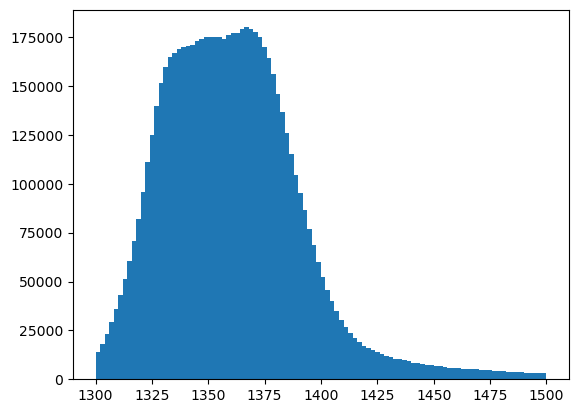

In [34]:
plt.figure()
plt.hist(oim.flatten(), bins = 100, range = (1300, 1500))
plt.show()

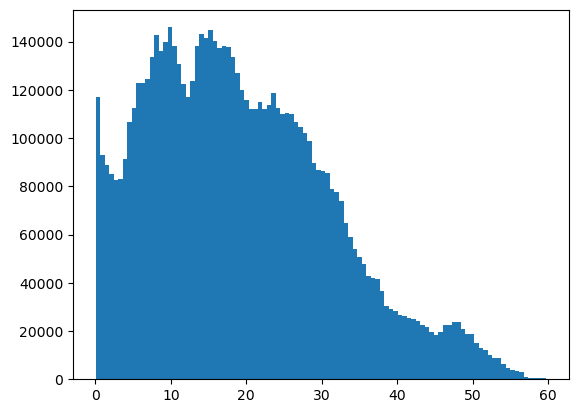

In [77]:
cirim[cirim == 1E-10] = np.nan
cirim[cirim == 0] = np.nan
plt.figure()
plt.hist(gaussian_filter(cirim, 20).flatten(), bins = 100)
plt.show()

In [65]:
#astcrop --mode=wcs --center=328.40009,17.699051 --width=0.3,0.3 -h1 --output=Euclid-VIS-ERO-Abell2390-LSB.DR3.dawis_cirrus_map.lvl4.crop.fits Euclid-VIS-ERO-Abell2390-LSB.DR3.dawis_cirrus_map.lvl4.fits


In [223]:
cirim = fits.getdata('/home/aellien/Euclid_ERO/data/Euclid-VIS-Stack-ERO-Abell2390.DR3/Euclid-VIS-ERO-Abell2390-LSB.DR3.dawis_cirrus_map.lvl4.rot.crop.scaled.fits')
oim = fits.getdata('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-Y-ERO-Abell2390-LSB.DR3.crop.fits')
test = oim - 0.5 * cirim
hduo = fits.PrimaryHDU(test)
hduo.writeto('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/test.fits', overwrite = True)

cirim = fits.getdata('/home/aellien/Euclid_ERO/data/Euclid-VIS-Stack-ERO-Abell2390.DR3/Euclid-VIS-ERO-Abell2390-LSB.DR3.dawis_cirrus_map.lvl4.rot.crop.scaled.fits')
oim = fits.getdata('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.fits')
test2 = oim - 0.4 * cirim
hduo = fits.PrimaryHDU(test2)
hduo.writeto('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/test2.fits', overwrite = True)

3.843534231185913 119.72159576416016
3.3463926315307617 119.48006057739258


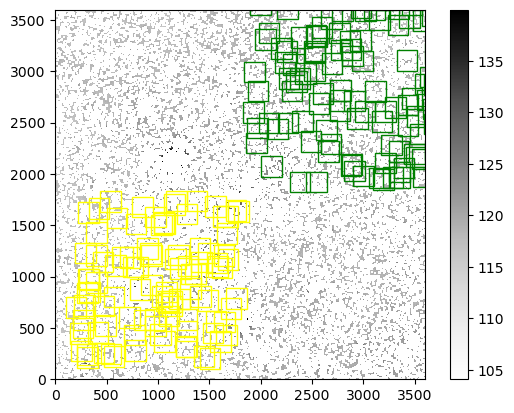

In [211]:
oim = fits.getdata('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.fits')
mask = fits.getdata('/home/aellien/Euclid_ERO/analysis/Abell_2390_NISP_mask_all_but_bcg_full_img_H_crop.fits')
oim[np.isnan(mask)] = np.nan
plt.figure()
plt.imshow(oim, norm = ImageNormalize( oim, interval = ZScaleInterval(), stretch = LinearStretch()), cmap = 'Grays', origin = 'lower')
np.random.seed()
drawX = np.random.randint(100, 1700, 100)
drawY = np.random.randint(100, 1700, 100)
stdl1 = []
meanl1 = []
n_sig = 3
for x, y in zip(drawX, drawY):
    #print(x, y, np.std(oim[x-100:x+100, y-100:y+100]))
    r = Rectangle((x, y), 200, 200, edgecolor='yellow', facecolor='none')
    plt.gca().add_patch(r)
    pix = sigma_clip(test2[x-100:x+100, y-100:y+100], sigma = n_sig, sigma_lower = n_sig, masked = False)
    stdl1.append(np.std(pix))
    meanl1.append(np.median(pix))
dat1 = np.array([stdl1, meanl1])
clip1 = sigma_clip(dat1, sigma = n_sig, sigma_lower = n_sig, axis = 1, masked = False)

drawX = np.random.randint(1800, 3601, 100)
drawY = np.random.randint(1800, 3601, 100)
stdl2 = []
meanl2 = []
for x, y in zip(drawX, drawY):
    #print(x, y, np.std(oim[x-100:x+100, y-100:y+100]))
    r = Rectangle((x, y), 200, 200, edgecolor='green', facecolor='none')
    plt.gca().add_patch(r)
    pix = sigma_clip(test2[x-100:x+100, y-100:y+100], sigma = n_sig, sigma_lower = n_sig, masked = False)

    stdl2.append(np.std(pix))
    meanl2.append(np.median(pix))
    
dat2 = np.array([stdl2, meanl2])
clip2 = sigma_clip(dat2, sigma = n_sig, sigma_lower = n_sig, axis = 1, masked = False)

print(np.nanmedian(clip1[0]), np.nanmedian(clip1[1]))
print(np.nanmedian(clip2[0]), np.nanmedian(clip2[1]))

plt.colorbar()
plt.show()

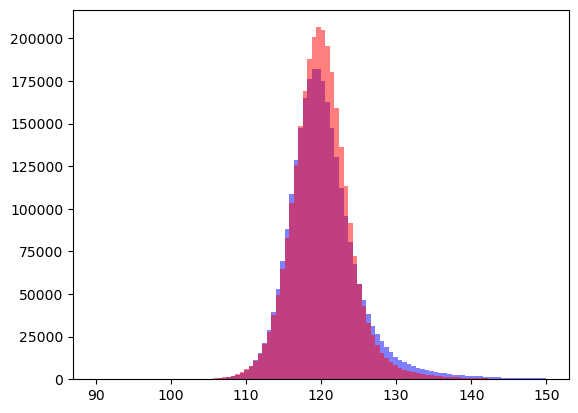

119.702614 119.871124 3.8281133 3.468185


In [220]:
oim = fits.getdata('/home/aellien/Euclid_ERO/data/Euclid-NISP-Stack-ERO-Abell2390.DR3/Euclid-NISP-J-ERO-Abell2390-LSB.DR3.crop.fits')
mask = fits.getdata('/home/aellien/Euclid_ERO/analysis/Abell_2390_NISP_mask_all_but_bcg_full_img_H_crop.fits')
oim[np.isnan(mask)] = np.nan
n_sig = 3
plt.figure()
plt.hist(oim[:1800, :1800].flatten(), color = 'blue', range = (90, 150), alpha = 0.5, bins = 100)
plt.hist(oim[1800:, 1800:].flatten(), color = 'red', range = (90, 150), alpha = 0.5, bins = 100)
plt.show()
pix1 = sigma_clip(oim[:1800, :1800], sigma = n_sig, sigma_lower = n_sig, masked = False)
pix2 = sigma_clip(oim[1800:, 1800:], sigma = n_sig, sigma_lower = n_sig, masked = False)
print(np.median(pix1), np.median(pix2), np.std(pix1), np.std(pix2))
